In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

# Cutting 

from cut_audio import *

%matplotlib inline

## Import Data

In [3]:
N = 100

train_audio_path = '../../Project/data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])

In [4]:
features_og = pd.DataFrame({('info','word',''): word,
                            ('info','speaker',''): speaker,
                            ('info','iteration',''): iteration,
                            ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
#features_og.set_index(index_og,inplace=True)
print('Number of signals : ' + str(len(features_og)))
features_og.head()

Number of signals : 3000


info                                                                  
  iteration                                               path   speaker word
                                                                             
0         0  ../../Project/data/train/audio/bed/7846fd85_no...  7846fd85  bed
1         0  ../../Project/data/train/audio/bed/51995cea_no...  51995cea  bed
2         1  ../../Project/data/train/audio/bed/6a203e0e_no...  6a203e0e  bed
3         1  ../../Project/data/train/audio/bed/0474c92a_no...  0474c92a  bed
4         0  ../../Project/data/train/audio/bed/15c371c7_no...  15c371c7  bed

## Extract the Features

### MFCCS  statistics (cut)

In [ ]:
N_MFCC = 10

def compute_mfcc(filepath):
    ''' 
    Cuts the signal to reduce the silences and computes the MFCC
    '''  
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    cut_version = cut_signal(audio)
    return librosa.feature.mfcc(y=cut_version,sr=sampling_rate, n_mfcc=N_MFCC)


stat_name= ['mean','std','skew','kurtosis','median']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
features_mfcc =pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
# sorting the columns in order to improve index performances (see lexsort errors)
features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

# MFCC FEATURES :
for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
    mfcc = compute_mfcc(features_og[('info','path')].iloc[w])
    features_mfcc.loc[w, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'std')] = np.std(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'median')] = np.median(mfcc,axis=1)

features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)
# Save features as pickle
features_og.to_pickle('./Features Data/cut_mfccs_10.pickle')
features_og.head()

 68%|██████▊   | 2027/3000 [09:32<04:34,  3.54waves/s]

### MFCCs raw (cut)

In [5]:
N_MFCC = 10
N_FFT =  int(2048/2)
NUM_MFCCS_VEC = 5

def compute_mfcc(filepath):
    ''' 
    Cuts the signal to reduce the silences and computes the MFCC
    '''  
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    cut_version = cut_signal(audio)
    mfccs = librosa.feature.mfcc(y=cut_version,sr=sampling_rate, n_mfcc=N_MFCC, n_fft = N_FFT, hop_length = int(np.floor(len(cut_version)/NUM_MFCCS_VEC)))
    return mfccs[:,:-1]

stat_name= ['raw_mfcc']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC*NUM_MFCCS_VEC)]
features_mfcc =pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
# sorting the columns in order to improve index performances (see lexsort errors)
features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

# MFCC FEATURES :
for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
    mfcc = compute_mfcc(features_og[('info','path')].iloc[w])
    features_mfcc.loc[w, ('mfcc', 'raw_mfcc')] = mfcc.reshape(-1,)


features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)
# Save features as pickle
features_og.to_pickle('./Features Data/cut_mfccs_raw_10_1028_5.pickle')
features_og.head()

100%|██████████| 3000/3000 [12:30<00:00,  4.00waves/s]


info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../../Project/data/train/audio/bed/7846fd85_no...  7846fd85  bed   
1         0  ../../Project/data/train/audio/bed/51995cea_no...  51995cea  bed   
2         1  ../../Project/data/train/audio/bed/6a203e0e_no...  6a203e0e  bed   
3         1  ../../Project/data/train/audio/bed/0474c92a_no...  0474c92a  bed   
4         0  ../../Project/data/train/audio/bed/15c371c7_no...  15c371c7  bed   

      mfcc                                                ...              \
  raw_mfcc                                                ...               
         0        1        2        3        4        5   ...          40   
0 -518.607 -219.421 -180.718 -190.083  -236.29   68.603   ...    -10.4221   
1 -739.032 -568.546 -388.788 -395.509 -581.481  148.531   ...     2.73401   
2  -357.19 -169.471 -178.325 -164.575 -344.926    68.12   ...     8.01755   
3 -380.412 -164.692 -167.224 -183.987  -214.62  59.1119   ...      8.6284   
4 -434.501  -166.17 -54.1217 -147.915 -346.463   82.594   ...     15.6221   

                                                                           \
                                                                            
        41       42       43       44       45       46       47       48   
0  18.9384  24.1173  20.7235  18.4684 -5.64985  -19.628 -11.2644 -14.7974   
1  1.84458 -22.0633  -13.625 -21.5049 -4.46863  -27.791 -4.70561  0.37106   
2  6.55873  13.8552  13.5544 -8.86286  5.42373  14.5683  18.6055  21.0638   
3  32.4299  33.6695  35.5856  31.1413   19.121  9.22734  11.7204  14.5851   
4 -25.6132  -13.897 -41.8281  -10.606  4.44877 -27.8419 -22.7576 -11.8162   

            
            
        49  
0 -4.52644  
1 -18.8352  
2  12.8827  
3  17.2044  
4 -16.6746  

[5 rows x 54 columns]

## Spectral clustering

In [6]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_raw_10_1028_5.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../../Project/data/train/audio/bed/7846fd85_no...  7846fd85  bed   
1         0  ../../Project/data/train/audio/bed/51995cea_no...  51995cea  bed   
2         1  ../../Project/data/train/audio/bed/6a203e0e_no...  6a203e0e  bed   
3         1  ../../Project/data/train/audio/bed/0474c92a_no...  0474c92a  bed   
4         0  ../../Project/data/train/audio/bed/15c371c7_no...  15c371c7  bed   

      mfcc                                                ...              \
  raw_mfcc                                                ...               
         0        1        2        3        4        5   ...          40   
0 -518.607 -219.421 -180.718 -190.083  -236.29   68.603   ...    -10.4221   
1 -739.032 -568.546 -388.788 -395.509 -581.481  148.531   ...     2.73401   
2  -357.19 -169.471 -178.325 -164.575 -344.926    68.12   ...     8.01755   
3 -380.412 -164.692 -167.224 -183.987  -214.62  59.1119   ...      8.6284   
4 -434.501  -166.17 -54.1217 -147.915 -346.463   82.594   ...     15.6221   

                                                                           \
                                                                            
        41       42       43       44       45       46       47       48   
0  18.9384  24.1173  20.7235  18.4684 -5.64985  -19.628 -11.2644 -14.7974   
1  1.84458 -22.0633  -13.625 -21.5049 -4.46863  -27.791 -4.70561  0.37106   
2  6.55873  13.8552  13.5544 -8.86286  5.42373  14.5683  18.6055  21.0638   
3  32.4299  33.6695  35.5856  31.1413   19.121  9.22734  11.7204  14.5851   
4 -25.6132  -13.897 -41.8281  -10.606  4.44877 -27.8419 -22.7576 -11.8162   

            
            
        49  
0 -4.52644  
1 -18.8352  
2  12.8827  
3  17.2044  
4 -16.6746  

[5 rows x 54 columns]

In [7]:
# drop features
features = pd.DataFrame(features_og['mfcc'])
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

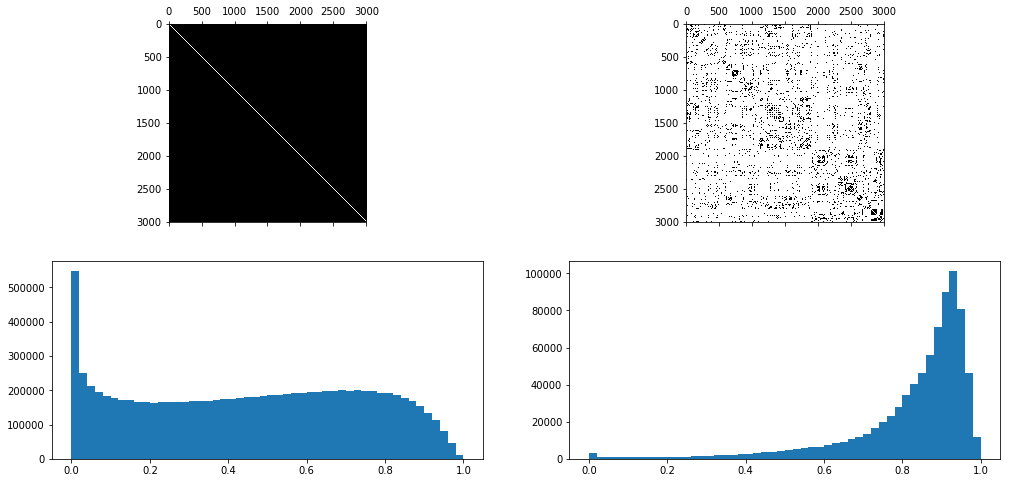

In [8]:

fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 400

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])
   

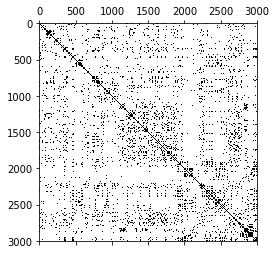

In [9]:
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
laplacian = sparse.csr_matrix(laplacian)
plt.spy(laplacian.todense());

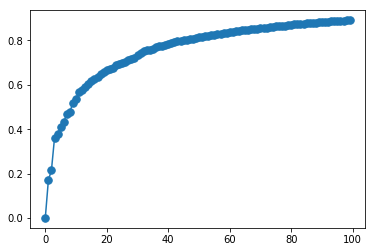

In [10]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=100,which='SM')
plt.plot(eigenvalues, '.-', markersize=15);


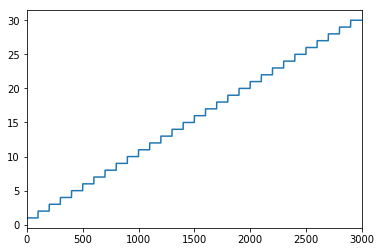

In [11]:
# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
label_vec = np.ones(len(features_og))
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) * i
    
label_vec.plot()

In [12]:
# sample classes such as test and train have equal proportion of classes
train_size = 80
test_size = 20

train_x = np.array([])
train_y = np.array([])

test_x = np.array([])
test_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(label_vec == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+test_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = label_vec[train_x_class]
    train_x = np.append(train_x, train_x_class)
    train_y = np.append(train_y, train_y_class)

    test_x_class = class_index[random_index[train_size:train_size+test_size]]
    test_y_class = label_vec[test_x_class]
    test_x = np.append(test_x, test_x_class)
    test_y = np.append(test_y, test_y_class)
    

In [13]:
# get features
train_features = eigenvectors[train_x.astype(int),:]
test_features = eigenvectors[test_x.astype(int),:]

In [14]:
clf  = GaussianNB()

In [15]:
clf.fit(train_features, train_y)

GaussianNB(priors=None)

In [16]:
predict_y = clf.predict(test_features)
print('accuracy : ', np.sum(test_y==predict_y)/len(test_y))

accuracy :  0.491666666667


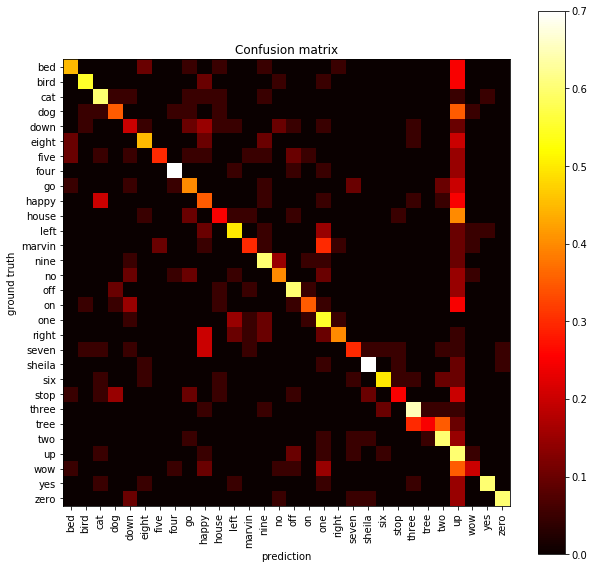

In [31]:
# confusion matrix from ADA
conf_mat=confusion_matrix(test_y,predict_y)

plt.figure(figsize=(10,10))
plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
tick = np.arange(len(class_names))
plt.xticks(tick, class_names,rotation=90)
plt.yticks(tick, class_names)
plt.ylabel('ground truth')
plt.xlabel('prediction')
plt.title('Confusion matrix')
plt.colorbar()